# 1. Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import json
import random
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from IPython.display import display, HTML
from google.colab import files
import zipfile
import time

# 2. Configuration and Setup

In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration settings
CONFIG = {
    'image_size': 128,        # Size to resize frames
    'batch_size': 4,          # Batch size for training
    'num_epochs': 10,         # Number of epochs to train
    'learning_rate': 1e-5,    # Learning rate for optimizer
    'weight_decay': 1e-5,     # Weight decay for regularization
    'dropout_rate': 0.5,      # Dropout rate
}

Using device: cpu


# 3. Kaggle Setup and Data Download

In [ ]:
# Install and setup Kaggle API
!pip install kaggle

# Create Kaggle directory
!mkdir -p ~/.kaggle

# Upload your kaggle.json file to Colab
print("Please upload your kaggle.json file (from your Kaggle account settings)")
uploaded = files.upload()

# Move and set permissions for the API key
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle setup
!kaggle datasets list

# Download a DeepFake dataset (DFDC preview dataset)
!kaggle datasets download -d dagnelies/deepfake-faces
!unzip -q deepfake-faces.zip -d /content/deepfake_dataset

# Set data paths
data_paths = {
    'dataset_path': '/content/deepfake_dataset/',
    'model_save': '/content/deepfake_detector.pt'
}

Please upload your kaggle.json file (from your Kaggle account settings)


Saving kaggle.json to kaggle.json
ref                                                                  title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance                 Student Habits vs Academic Performance               19512  2025-04-12 10:49:08.663000          10533        185  1.0              
zahidmughal2343/global-cancer-patients-2015-2024                     global_cancer_patients_2015_2024                   1261049  2025-04-14 00:05:23.367000           2724         36  1.0              
devdope/200k-spotify-songs-light-dataset                             🎧 200K+ Spotify Songs Light Dataset               17660144  2025-04-16 21:03:24.003000       

# 4. Helper Classes and Functions

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class DeepfakeImageDataset(Dataset):
    def __init__(self, metadata_df, transform=None):
        self.metadata_df = metadata_df
        self.transform = transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        image_path = row['path']

        # Get label
        label = 0 if row['label'] == 'FAKE' else 1  # 0 for FAKE, 1 for REAL

        # Load image
        try:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply transformations
            if image is not None and self.transform:
                image = self.transform(image)
            else:
                # Fallback if image loading fails
                image = torch.zeros((3, CONFIG['image_size'], CONFIG['image_size']))
        except:
            # Fallback for any errors
            image = torch.zeros((3, CONFIG['image_size'], CONFIG['image_size']))

        return image, label

# 5. Create Metadata and Prepare Data

total 7192
drwxr-xr-x 3 root root    4096 May  2 07:17 .
drwxr-xr-x 1 root root    4096 May  2 07:16 ..
drwxr-xr-x 2 root root 3493888 May  2 07:17 faces_224
-rw-r--r-- 1 root root 3855604 Feb  2  2020 metadata.csv
First few rows of metadata:


,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


CSV columns: ['videoname', 'original_width', 'original_height', 'label', 'original']
Total videos/images: 95634
Fake videos/images: 79341
Real videos/images: 16293


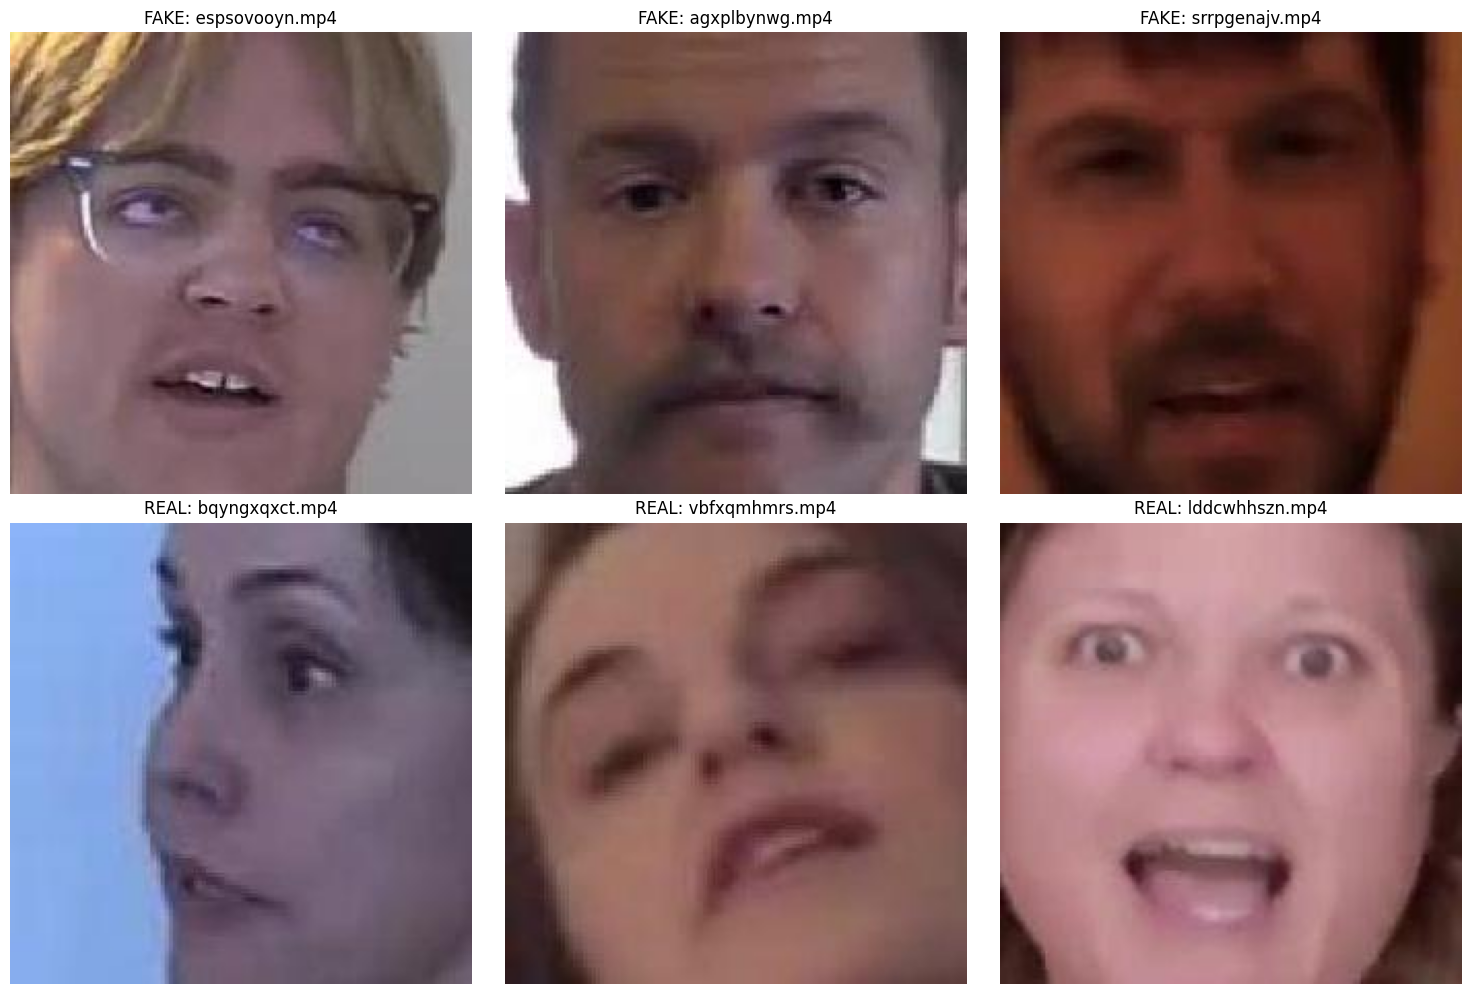

In [ ]:
# Let's check what's in our dataset directory
!ls -la /content/deepfake_dataset/

# Create metadata DataFrame from CSV
csv_path = os.path.join(data_paths['dataset_path'], 'metadata.csv')
metadata = pd.read_csv(csv_path)

# Display the first few rows
print("First few rows of metadata:")
display(metadata.head())

# Check the column names
print("CSV columns:", metadata.columns.tolist())

# Create a copy for processing
valid_df = metadata.copy()

# Map image paths
faces_dir = os.path.join(data_paths['dataset_path'], 'faces_224')
valid_df['path'] = valid_df['videoname'].apply(
    lambda x: os.path.join(faces_dir, x.replace('.mp4', '.jpg'))
)

# Check that the paths exist
valid_df = valid_df[valid_df['path'].apply(os.path.exists)]

print(f"Total videos/images: {len(valid_df)}")
print(f"Fake videos/images: {len(valid_df[valid_df['label'] == 'FAKE'])}")
print(f"Real videos/images: {len(valid_df[valid_df['label'] == 'REAL'])}")

# Optional: Display some sample images
plt.figure(figsize=(15, 10))
for i, category in enumerate(['FAKE', 'REAL']):
    samples = valid_df[valid_df['label'] == category].sample(3)
    for j, (_, row) in enumerate(samples.iterrows()):
        plt.subplot(2, 3, i*3 + j + 1)
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"{category}: {row['videoname']}")
        plt.axis('off')
plt.tight_layout()
plt.show()


# 6. Split Data and Define Transforms

In [ ]:
# Limit the dataset to a small sample for faster training
sample_size = 36000  # I chose this value as a max sample size

# Ensure balanced sampling between real and fake
fake_df = valid_df[valid_df['label'] == 'FAKE'].sample(min(sample_size // 2, len(valid_df[valid_df['label'] == 'FAKE'])))
real_df = valid_df[valid_df['label'] == 'REAL'].sample(min(sample_size // 2, len(valid_df[valid_df['label'] == 'REAL'])))
metadata_df = pd.concat([fake_df, real_df])
print(f"Using a balanced sample of {len(metadata_df)} images")

# Split data
train_df, val_df = train_test_split(
    metadata_df,
    test_size=0.2,
    random_state=42,
    stratify=metadata_df['label']  # Ensure balanced classes
)

print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")

# Define transformations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


Using a balanced sample of 34293 images
Training images: 27434
Validation images: 6859


# 7. Define the Model

In [ ]:
class DeepFakeImageDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepFakeImageDetector, self).__init__()

        # Use EfficientNet as base model
        self.model = models.efficientnet_b0(pretrained=True)

        # Replace classifier
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = DeepFakeImageDetector().to(device)
print(model)

# Summary of model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 50.1MB/s]


DeepFakeImageDetector(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              

# 8. Create Data Loaders

Batch shape: torch.Size([4, 3, 128, 128])
Labels: tensor([0, 0, 1, 0])


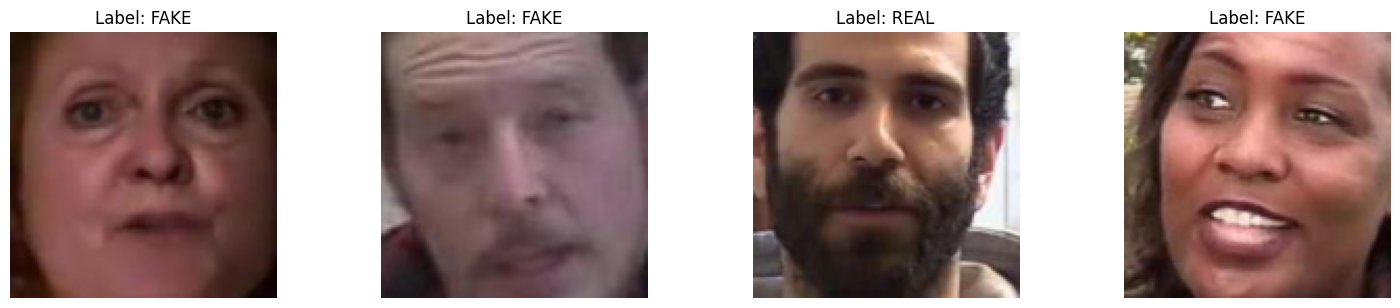

In [ ]:
# Create datasets
train_dataset = DeepfakeImageDataset(train_df, transform=transform)
val_dataset = DeepfakeImageDataset(val_df, transform=transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Check a batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels: {labels}")

# Display a batch of images
plt.figure(figsize=(15, 6))
for i in range(min(8, CONFIG['batch_size'])):
    plt.subplot(2, 4, i+1)
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    # Denormalize
    img = img * np.array(std) + np.array(mean)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Label: {'REAL' if labels[i] == 1 else 'FAKE'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#9. Define Loss, Optimizer, and Helper Functions

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

def calculate_accuracy(outputs, targets):
    """Calculate accuracy from model outputs and targets"""
    _, preds = torch.max(outputs, 1)
    correct = (preds == targets).float().sum()
    accuracy = correct / targets.size(0) * 100
    return accuracy.item()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#10. Training Loop

In [ ]:
from google.colab import files  # Add this at the top of your notebook

###########################################
# Cell 10: Training Loop (Modified)
###########################################
# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
best_val_acc = 0
for epoch in range(1, CONFIG['num_epochs'] + 1):
    print(f"Epoch {epoch}/{CONFIG['num_epochs']}")

    # Train
    model.train()
    train_loss_meter = AverageMeter()
    train_acc_meter = AverageMeter()

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Calculate accuracy
        acc = calculate_accuracy(outputs, targets)

        # Update metrics
        train_loss_meter.update(loss.item(), inputs.size(0))
        train_acc_meter.update(acc, inputs.size(0))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if (i + 1) % 10 == 0 or (i + 1) == len(train_loader):
            print(f"\r[Epoch {epoch}/{CONFIG['num_epochs']}] [Batch {i+1}/{len(train_loader)}] "
                  f"[Loss: {train_loss_meter.avg:.4f}, Acc: {train_acc_meter.avg:.2f}%]", end="")

    print()  # New line after epoch
    train_loss, train_acc = train_loss_meter.avg, train_acc_meter.avg

    # Validate
    model.eval()
    val_loss_meter = AverageMeter()
    val_acc_meter = AverageMeter()
    all_targets = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Get predictions
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # Calculate accuracy
            acc = calculate_accuracy(outputs, targets)

            # Store predictions and targets
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())

            # Update metrics
            val_loss_meter.update(loss.item(), inputs.size(0))
            val_acc_meter.update(acc, inputs.size(0))

            # Print progress
            if (i + 1) % 5 == 0 or (i + 1) == len(val_loader):
                print(f"\r[Validation] [Batch {i+1}/{len(val_loader)}] "
                      f"[Loss: {val_loss_meter.avg:.4f}, Acc: {val_acc_meter.avg:.2f}%]", end="")

    val_loss, val_acc = val_loss_meter.avg, val_acc_meter.avg
    print(f"\nValidation Accuracy: {val_acc:.2f}%")

    # Update learning rate
    scheduler.step(val_loss)

    # Save metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), data_paths['model_save'])
        print(f"Model saved with acc: {val_acc:.2f}%")

# Download the saved model
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
print("Downloading best model...")
files.download(data_paths['model_save'])


NameError: name 'CONFIG' is not defined

#11. Evaluation and Visualization

Final Evaluation Metrics:
True Negative: 2913
False Positive: 687
False Negative: 535
True Positive: 2724
Precision: 0.7986
Recall: 0.8358
F1 Score: 0.8168


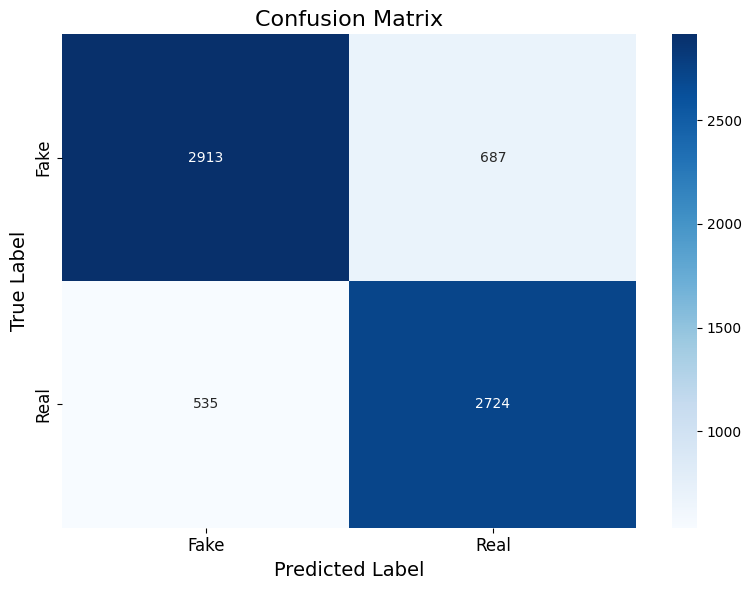

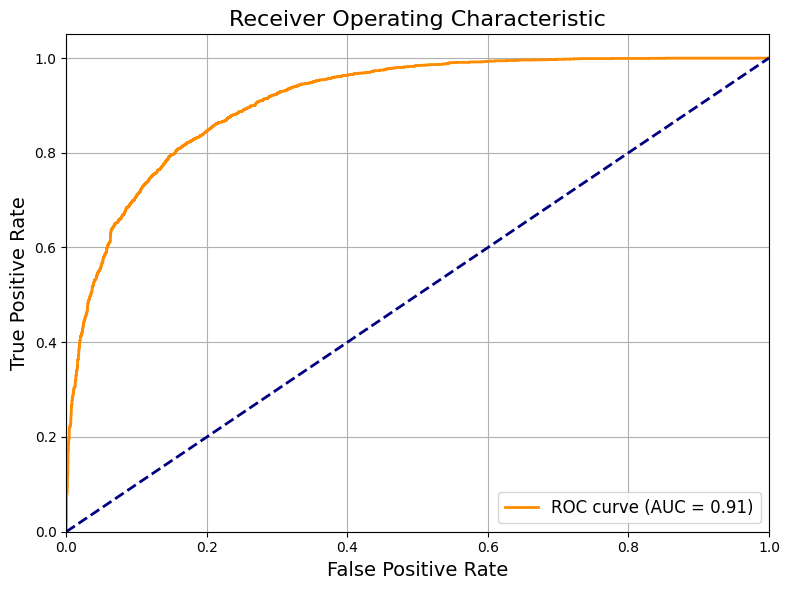

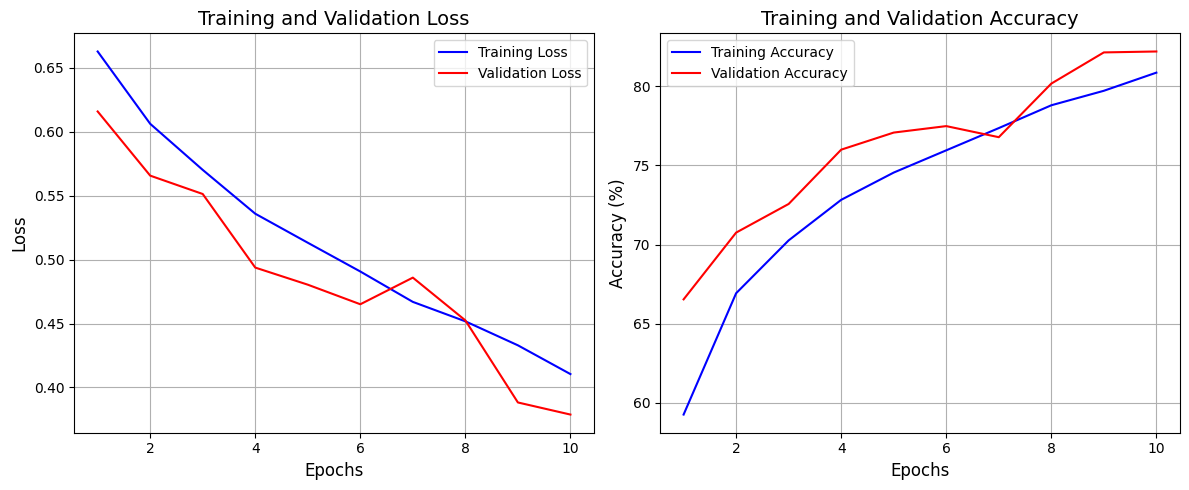

In [ ]:
# Plot confusion matrix
targets, predictions = np.array(all_targets), np.array(all_predictions)
cm = confusion_matrix(targets, predictions)

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("Final Evaluation Metrics:")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks([0.5, 1.5], ['Fake', 'Real'], fontsize=12)
plt.yticks([0.5, 1.5], ['Fake', 'Real'], fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot learning curves
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#12. Test With Example Images (Standalone)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from /content/deepfake_detector.pt
Please upload some images to test the model:


Saving Capture d’écran 2025-05-02 015153.png to Capture d’écran 2025-05-02 015153.png


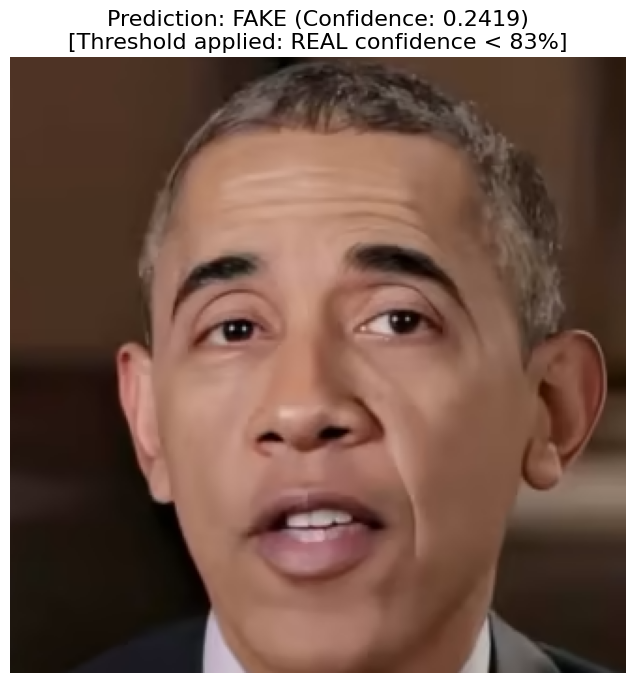

Results for Capture d’écran 2025-05-02 015153.png:
Prediction: FAKE
Note: Original REAL probability was 0.7581 but threshold was applied
Confidence: 0.2419
Probability Real: 0.7581
Probability Fake: 0.2419
----------------------------------------


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np

# Configuration for dropout
CONFIG = {
    'dropout_rate': 0.3  # same dropout as during training
}

# Define the model class
class DeepFakeImageDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepFakeImageDetector, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # EfficientNet-B0 input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = DeepFakeImageDetector().to(device)
print(f"Loading model from {'/content/deepfake_detector.pt'}")
model.load_state_dict(torch.load('/content/deepfake_detector.pt', map_location=device))
model.eval()

# Face extraction function
def extract_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        return None
    x, y, w, h = max(faces, key=lambda f: f[2]*f[3])
    padding = 30
    face = image[max(0, y-padding):y+h+padding, max(0, x-padding):x+w+padding]
    return face

# Upload test images
print("Please upload some images to test the model:")
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_image = extract_face(image)
    if face_image is None:
        print(f"{filename}: No face detected!")
        continue

    plt.figure(figsize=(10, 8))
    plt.imshow(face_image)

    input_tensor = transform(face_image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

        if prediction == 1 and confidence < 0.78:
            prediction = 0
            confidence = probabilities[0][0].item()

    label = "REAL" if prediction == 1 else "FAKE"
    result = {
        "prediction": label,
        "confidence": float(confidence),
        "probability_fake": float(probabilities[0][0].item()),
        "probability_real": float(probabilities[0][1].item()),
        "threshold_applied": (label == "FAKE" and probabilities[0][1].item() > probabilities[0][0].item())
    }

    title = f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})"
    if result['threshold_applied']:
        title += "\n[Threshold applied: REAL confidence < 83%]"
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

    print(f"Results for {filename}:")
    print(f"Prediction: {result['prediction']}")
    if result['threshold_applied']:
        print(f"Note: Original REAL probability was {result['probability_real']:.4f} but threshold was applied")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probability Real: {result['probability_real']:.4f}")
    print(f"Probability Fake: {result['probability_fake']:.4f}")
    print("-" * 40)


#13. Enhanced DeepFake Detection API with Face Detection
###   – single image
###   – multiple images
###   – video (1 frame/sec)

In [ ]:
!pip install flask_cors
!pip install pyngrok
# === Imports ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import cv2
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok, conf
from threading import Thread
import socket
import time
import tempfile
import os
import io

inference_times = []
# === Configuration ===
CONFIG = {
    'dropout_rate': 0.3,
    'real_confidence_threshold': 0.5,  # Threshold for "real" classification
    'face_padding': 30  # Padding around detected faces
}
MODEL_PATH = "/content/deepfake_detector.pt"

# === Define Model ===
class DeepFakeImageDetector(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(num_ftrs, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# === Load Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeImageDetector().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Load face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# === Preprocessing ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === Face Extraction Function ===
def extract_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        return None

    # Get the largest face by area
    x, y, w, h = max(faces, key=lambda f: f[2]*f[3])
    padding = CONFIG['face_padding']
    face = image[max(0, y-padding):min(image.shape[0], y+h+padding),
                 max(0, x-padding):min(image.shape[1], x+w+padding)]

    # Check if the face region is empty or too small
    if face.size == 0 or face.shape[0] < 20 or face.shape[1] < 20:
        return None

    return face

# === Prediction Function with Confidence Threshold and Inference Time Measurement===
def predict_with_face(image):
    # Convert to RGB if needed
    if len(image.shape) == 3 and image.shape[2] == 3:
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
    else:
        return {"error": "Invalid image format"}

    # Convert BGR to RGB if necessary
    if image.shape[2] == 3:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = image

    # Extract face
    face_image = extract_face(rgb_image)
    if face_image is None:
        return {"error": "No face detected in the image"}

    # Transform
    input_tensor = transform(face_image).unsqueeze(0).to(device)

    # Measure inference time
    inference_start = time.time()

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
    inference_time = time.time() - inference_start
    print(f"Inference time per image: {inference_time*1000:.2f} ms")
    print(f"Average inference time: {(sum(inference_times)/len(inference_times))*1000:.2f} ms (over {len(inference_times)} images)")
    inference_times.append(inference_time)
    probability_fake = float(probabilities[0][0].item())
    probability_real = float(probabilities[0][1].item())

    # Apply confidence threshold for "real" classification
    if probability_real > probability_fake and probability_real < CONFIG['real_confidence_threshold']:
        prediction = "FAKE"
        confidence = probability_fake
        threshold_applied = True
    else:
        prediction = "REAL" if probability_real > probability_fake else "FAKE"
        confidence = probability_real if prediction == "REAL" else probability_fake
        threshold_applied = False

    return {
        "prediction": prediction,
        "confidence": confidence,
        "probability_fake": probability_fake,
        "probability_real": probability_real,
        "threshold_applied": threshold_applied
    }

# === Flask App ===
app = Flask("DeepFakeDetectorAPI")
CORS(app)

@app.route("/", methods=["GET"])
def home():
    return jsonify({
        "status": "API running",
        "endpoints": {
            "/predict": "Single image analysis",
            "/predict/batch": "Multiple images analysis",
            "/predict/video": "Video analysis (1 frame/sec)"
        }
    })

def predict_image_file(file_stream):
    try:
        # Read image
        img_bytes = file_stream.read()
        arr = np.frombuffer(img_bytes, np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
        if img is None:
            return {"error": "Could not decode image"}

        # Make prediction
        result = predict_with_face(img)
        return result
    except Exception as e:
        return {"error": f"Image processing error: {str(e)}"}

@app.route("/predict", methods=["POST"])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    result = predict_image_file(request.files['file'])

    if "error" in result:
        return jsonify(result), 400

    return jsonify(result)

@app.route("/predict/batch", methods=["POST"])
def predict_batch():
    files = request.files.getlist('files')
    if not files:
        return jsonify({"error": "No files uploaded"}), 400

    results = []
    errors = []
    total_inference_time = 0
    num_processed = 0

    for file in files:
        result = predict_image_file(file)
        if "error" in result:
            errors.append({"filename": file.filename, "error": result["error"]})
        else:
            results.append({"filename": file.filename, **result})
            num_processed += 1

    if num_processed > 0:
        print(f"Processed {num_processed} images in batch")

    return jsonify({
        "results": results,
        "errors": errors,
        "summary": {
            "total": len(files),
            "processed": len(results),
            "failed": len(errors)
        }
    })

@app.route("/predict/video", methods=["POST"])
def predict_video():
    if 'file' not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    # Configuration for video processing
    MAX_FRAMES = 50  # Maximum number of frames to analyze

    start_time = time.time()
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_video.mp4")

    try:
        # Save the uploaded file
        request.files['file'].save(temp_path)

        # Open the video file
        cap = cv2.VideoCapture(temp_path)
        if not cap.isOpened():
            return jsonify({"error": "Could not open video file"}), 400

        # Get video properties
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        if total_frames <= 0:
            return jsonify({"error": "Invalid video: couldn't determine frame count"}), 400

        # Calculate frames to sample (evenly distributed)
        frames_to_sample = min(MAX_FRAMES, total_frames)

        if frames_to_sample == 1:
            # For very short videos, just take the middle frame
            frame_indices = [total_frames // 2]
        else:
            # Evenly distribute frames across the video
            frame_indices = [int(i * total_frames / frames_to_sample) for i in range(frames_to_sample)]

        frame_results = []
        faces_detected = 0
        total_inference_time = 0

        for frame_idx in frame_indices:
            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                continue

            # Process the frame
            result = predict_with_face(frame)

            if "error" not in result:
                faces_detected += 1
                frame_results.append({
                    "frame_index": frame_idx,
                    "timestamp": frame_idx / fps if fps > 0 else 0,
                    **result
                })

        cap.release()

        # Clean up the temporary file
        try:
            os.remove(temp_path)
        except:
            pass

        if faces_detected == 0:
            return jsonify({
                "error": "No faces detected in any analyzed frames",
                "frames_analyzed": len(frame_indices),
                "total_frames": total_frames
            }), 400

        # Calculate average probabilities across frames
        avg_real = sum(r["probability_real"] for r in frame_results) / len(frame_results)
        avg_fake = sum(r["probability_fake"] for r in frame_results) / len(frame_results)

        # Apply threshold to final result
        if avg_real > avg_fake and avg_real < CONFIG['real_confidence_threshold']:
            final_prediction = "FAKE"
            confidence = avg_fake
            threshold_applied = True
        else:
            final_prediction = "REAL" if avg_real > avg_fake else "FAKE"
            confidence = avg_real if final_prediction == "REAL" else avg_fake
            threshold_applied = False

        processing_time = time.time() - start_time
        print(f"Total video processing time: {processing_time:.2f} seconds for {faces_detected} frames with faces")
        if faces_detected > 0:
            print(f"Average processing time per frame: {processing_time/faces_detected*1000:.2f} ms")

        return jsonify({
            "prediction": final_prediction,
            "confidence": confidence,
            "probability_real": avg_real,
            "probability_fake": avg_fake,
            "threshold_applied": threshold_applied,
            "faces_detected": faces_detected,
            "frames_analyzed": len(frame_indices),
            "frames_with_faces": faces_detected,
            "processing_time_seconds": round(processing_time, 2),
            "total_frames": total_frames,
            "frame_results": frame_results
        })

    except Exception as e:
        return jsonify({"error": f"Video processing error: {str(e)}"}), 500

# === Launch ===
def find_free_port():
    with socket.socket() as s:
        s.bind(('',0))
        return s.getsockname()[1]

port = find_free_port()
Thread(target=lambda: app.run('0.0.0.0', port=port), daemon=True).start()

conf.get_default().auth_token = "2wPKLhrhwBZNvGeJ7fHCkHKS4GJ_23HK52NusZgoDmXDf8dRk"
public_url = ngrok.connect(port)
print(f"API publicly available at: {public_url}/")
print("POST to /predict, /predict/batch or /predict/video")
print("\nServer running... Press Ctrl+C to quit")
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\nServer stopped.")

 * Serving Flask app 'DeepFakeDetectorAPI'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:49817
 * Running on http://172.28.0.12:49817
INFO:werkzeug:Press CTRL+C to quit


API publicly available at: NgrokTunnel: "https://9053-34-122-15-234.ngrok-free.app" -> "http://localhost:49817"/
POST to /predict, /predict/batch or /predict/video

Server running... Press Ctrl+C to quit
Inference time per image: 107.85 ms
Inference time per image: 69.17 ms
Inference time per image: 65.97 ms
Inference time per image: 73.40 ms
Inference time per image: 66.81 ms
Inference time per image: 68.01 ms
Inference time per image: 71.29 ms
Inference time per image: 65.76 ms
Inference time per image: 67.21 ms
Inference time per image: 93.17 ms
Inference time per image: 88.82 ms
Inference time per image: 68.56 ms
Inference time per image: 67.14 ms
Inference time per image: 87.15 ms
Inference time per image: 81.24 ms
Inference time per image: 69.76 ms
Inference time per image: 67.06 ms
Inference time per image: 71.22 ms
Inference time per image: 70.44 ms


INFO:werkzeug:127.0.0.1 - - [03/May/2025 23:33:54] "POST /predict/batch HTTP/1.1" 200 -


Inference time per image: 92.19 ms

Server stopped.


# 14. Test API with Sample Image

Testing API with a sample image from our dataset...
Selected image: /content/deepfake_dataset/faces_224/zanvojxaau.jpg
True label: FAKE


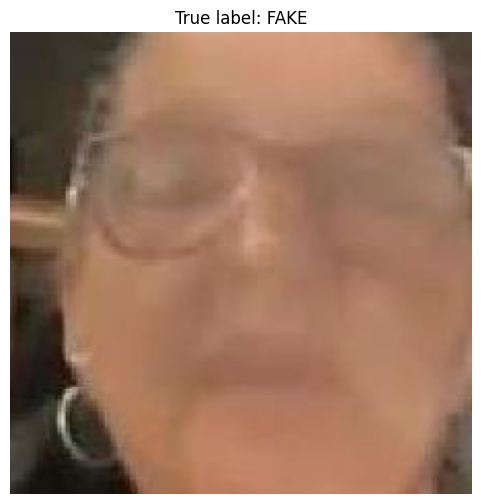

InvalidSchema: No connection adapters were found for 'NgrokTunnel: "https://a430-34-106-182-181.ngrok-free.app" -> "http://localhost:50675"/predict'

In [ ]:
# test the API with a sample image from our dataset
print("Testing API with a sample image from our dataset...")

# Select a random image from the validation set
sample_idx = np.random.randint(0, len(val_df))
sample_path = val_df.iloc[sample_idx]['path']
sample_true_label = val_df.iloc[sample_idx]['label']

print(f"Selected image: {sample_path}")
print(f"True label: {sample_true_label}")

# Display the image
sample_image = cv2.imread(sample_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"True label: {sample_true_label}")
plt.axis('off')
plt.show()

# Test the API directly
img_bytes = cv2.imencode('.jpg', sample_image)[1].tobytes()
from io import BytesIO
import requests

# Create a file-like object
file_like = BytesIO(img_bytes)
file_like.name = 'sample.jpg'

# Send a request to our API
response = requests.post(
    f"{public_url}/predict",
    files={'file': file_like}
)

result = response.json()
print("API Response:")
print(json.dumps(result, indent=4))

# Check if prediction matches true label
true_label_binary = 1 if sample_true_label == 'REAL' else 0
predicted_label_binary = 1 if result['prediction'] == 'REAL' else 0
is_correct = true_label_binary == predicted_label_binary

print(f"Prediction is {'correct' if is_correct else 'incorrect'}")


In [ ]:
# Optionnal command to close the tunnel and kill all my personnal ngrok sessions
ngrok.kill()

#15. Final Summary

DeepFake Detection System Summary
Model Type: EfficientNet-B0 for Image Classification
Dataset Size: 34293 images
Training Images: 27434
Validation Images: 6859
Best Validation Accuracy: 82.18%
F1 Score: 0.8168

Model Assets Created:
- PyTorch Model: /content/deepfake_detector.pt

Deployment Endpoints:
- API Endpoint: NgrokTunnel: "https://6295-35-185-95-184.ngrok-free.app" -> "http://localhost:34345"/predict
- Web Interface: NgrokTunnel: "https://6295-35-185-95-184.ngrok-free.app" -> "http://localhost:34345"/interface
- API Info: NgrokTunnel: "https://6295-35-185-95-184.ngrok-free.app" -> "http://localhost:34345"/info

Model Interpretation Example:
Generating heatmap for a sample fake image...


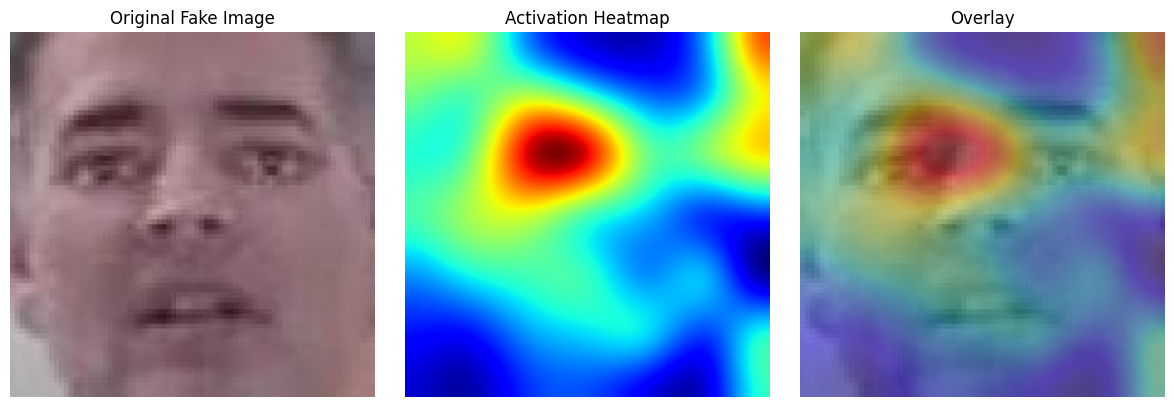


The heatmap shows areas the model focuses on when detecting fake images.
Areas highlighted in red are regions the model finds most important for classification.


In [ ]:
print("DeepFake Detection System Summary")
print("=" * 40)
print(f"Model Type: EfficientNet-B0 for Image Classification")
print(f"Dataset Size: {len(metadata_df)} images")
print(f"Training Images: {len(train_df)}")
print(f"Validation Images: {len(val_df)}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"F1 Score: {f1:.4f}")
print("=" * 40)
print("\nModel Assets Created:")
print(f"- PyTorch Model: {data_paths['model_save']}")
print("\nDeployment Endpoints:")
print(f"- API Endpoint: {public_url}/predict")
print(f"- Web Interface: {public_url}/interface")
print(f"- API Info: {public_url}/info")
print("=" * 40)

# Generate a heatmap visualization for a sample fake image
print("\nModel Interpretation Example:")
print("Generating heatmap for a sample fake image...")

# Get a sample fake image
fake_sample = val_df[val_df['label'] == 'FAKE'].sample(1).iloc[0]
fake_image_path = fake_sample['path']
fake_image = cv2.imread(fake_image_path)
fake_image = cv2.cvtColor(fake_image, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(fake_image)
plt.title("Original Fake Image")
plt.axis('off')

# Generate a simple heatmap visualization
from scipy.ndimage import zoom

# Preprocess the image
input_tensor = transform(fake_image).unsqueeze(0).to(device)

# Get activation maps from the last convolutional layer
# Note: This is a simplified version and not a true GradCAM
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hook
model.model.features[-1].register_forward_hook(get_activation('features'))

# Forward pass
with torch.no_grad():
    output = model(input_tensor)
    prob = F.softmax(output, dim=1)

    # Get activation map
    act = activation['features'].squeeze().cpu().numpy()

    # Use mean across channels for simplicity
    heatmap = np.mean(act, axis=0)

    # Resize heatmap to image size
    heatmap = zoom(heatmap,
                  (fake_image.shape[0] / heatmap.shape[0],
                   fake_image.shape[1] / heatmap.shape[1]))

    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Display heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Activation Heatmap")
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(fake_image)
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\nThe heatmap shows areas the model focuses on when detecting fake images.")
print("Areas highlighted in red are regions the model finds most important for classification.")